In [1]:
# %pip install --quiet netket
import netket as nk
from numpy.lib.function_base import append
from itertools import permutations, combinations
from netket.vqs.mc import get_local_kernel_arguments, get_local_kernel
import time
import matplotlib.pyplot as plt
import json
import numpy as np
from numpy.linalg import eig
from flax.core.frozen_dict import FrozenDict
import flax
from netket.optimizer.qgt import QGTJacobianPyTree


from typing import Callable, Tuple
from functools import partial

import jax
from jax import numpy as jnp

from netket.stats import statistics as mpi_statistics, mean as mpi_mean, Stats
from netket.utils.types import PyTree
from netket.operator.spin import sigmax, sigmay,sigmaz

import matplotlib.pyplot as plt
from tqdm import tqdm
################################################################
from scipy.sparse.linalg import eigsh
################################################################
import os
import pandas as pd



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from netket.graph import Chain
from netket.models import GCNN

# Define a 1d chain
L = 10
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
#g.translation_group
#g.point_group
#g.rotation_group
#g.space_group

hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)

# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
           for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])
# E, vec = eigsh((ha).to_dense(), k=2**L)
E, vec = np.linalg.eigh(ha.to_dense())


# plt.plot([0,2**L-1],[0,0],'r')
# plt.plot([0,2**L-1],[6.46555,6.46555],'g')
# plt.plot([0,2**L-1],[-1,-1],'r')

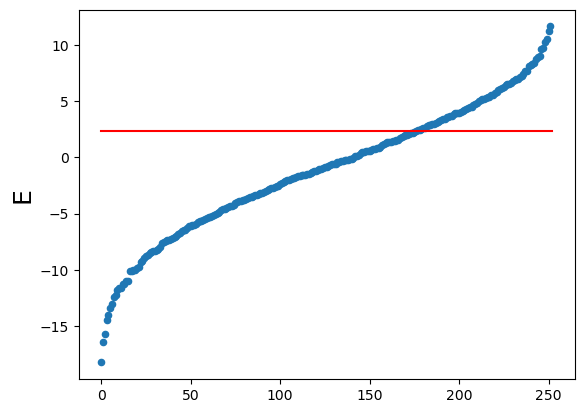

In [3]:
Et = L*np.random.uniform(low=0, high=1, size=None)

# print(E)
# print(np.sort(E_np))
# plt.scatter(np.arange(len(E)),np.sort(E),s=20)
plt.scatter(np.arange(len(E)),E,s=20)
plt.ylabel('E',fontsize=18)
plt.plot([0,len(E)],[Et,Et],'r')

In [4]:
E_sq, vec_sq = np.linalg.eigh(((ha-Et)@(ha-Et)).to_dense())
min(E_sq)

0.0008731723032732398

In [5]:
Et

2.353075909875788

In [6]:
def alpha_depen(samples, hilb, gra, Target, n_steps, alpha_, eta, eta_sr):



  ma = nk.models.RBM(alpha=alpha_, param_dtype=complex)
  sa = nk.sampler.MetropolisExchange(hilbert=hilb,graph=gra,d_max=1, n_chains=16)
  # vs = nk.vqs.FullSumState(hi, ma)
  vs = nk.vqs.MCState(sa, ma, n_samples=samples)
  op = nk.optimizer.Sgd(learning_rate=eta)
  sr = nk.optimizer.SR(diag_shift=eta_sr, holomorphic=True)



  gs = nk.VMC(
      hamiltonian=Target,
      optimizer=op,
      preconditioner=sr,
      variational_state=vs)

  # gs = nk.VMC(
  #     hamiltonian=Target,
  #     optimizer=op,
  #     variational_state=vs)

  start = time.time()
  gs.run(n_steps, out='RBM')
  end = time.time()
  data=json.load(open("RBM.log"))

  energy = vs.expect(ha).mean.real
  variance = vs.expect(ha@ha).mean.real-vs.expect(ha).mean.real**2
  print([energy, variance])
  return energy, variance;

In [7]:
def alpha_depen(samples, hilb, gra, Target, n_steps, alpha_, eta, eta_sr):



  ma = nk.models.RBM(alpha=alpha_, param_dtype=complex)
  sa = nk.sampler.MetropolisExchange(hilbert=hilb,graph=gra,d_max=1, n_chains=16)
  # vs = nk.vqs.FullSumState(hi, ma)
  vs = nk.vqs.MCState(sa, ma, n_samples=samples)
  op = nk.optimizer.Sgd(learning_rate=eta)
  sr = nk.optimizer.SR(diag_shift=eta_sr, holomorphic=True)



  gs = nk.VMC(
      hamiltonian=Target,
      optimizer=op,
      preconditioner=sr,
      variational_state=vs)

  # gs = nk.VMC(
  #     hamiltonian=Target,
  #     optimizer=op,
  #     variational_state=vs)

  start = time.time()
  gs.run(n_steps, out='RBM')
  end = time.time()
  data=json.load(open("RBM.log"))

  energy = vs.expect(ha).mean.real
  variance = vs.expect(ha@ha).mean.real-vs.expect(ha).mean.real**2
  print([energy, variance])
  return energy, variance

In [8]:
alpha_depen(2048, hi, g, (ha-Et)@(ha-Et), 20000, 2, 0.001, 0.01)

100%|█| 20000/20000 [2:59:00<00:00,  1.86it/s, Energy=0.273-0.001j ± 0.018 [σ²=0


[Array(2.34402866, dtype=float64), Array(0.31394341, dtype=float64)]


(Array(2.34402866, dtype=float64), Array(0.31394341, dtype=float64))